In [1]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

Projekt zaliczeniowy PSI- Piotr Kubacki
Temat: Przewidywanie zawału na podstawie danych medycznych

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
del data['id']
data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [4]:
for col in (data['gender'],data['ever_married'],data['work_type'],data['Residence_type'],data['smoking_status']):
    print(col.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


W kolumnie smoking_status mamy do uzupełnienia wartości 'Unknown'. Przyjrzyjmy się temu

In [5]:
len(data.loc[data['smoking_status'] == 'Unknown'])/len(data)

0.3021526418786693

30% to dużo. Możemy pozbyć się tej kolumny albo jakoś ją uzupełnić. Zdrowy rozsądek podpowiada jednak, że status palacza ma duży, a może nawet decydujący wpływ na ewentualność zawału. Zachowamy więc naszą kolumnę, uzupełnimy dane przez modę z kolumny.

In [6]:
mode=data['smoking_status'].mode()  # wychodzi ze najczesciej jest 'never smoked'.

In [7]:
mode='never smoked'

In [8]:
data['smoking_status']=data['smoking_status'].replace('Unknown',mode)
data['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Poza tym, mamy względnie dobrze uporządkowane dane. Wartości w kolumnach kategorycznych są jednoznaczne. Nie ma zbyt wiele wybrakowanych wartości w kolumnach. Musimy jedynie uzupełnić stosunkowo niewiele wartości dla bmi. Wstawimy tam po prostu średnią z całej kolumny

In [10]:
mean_test = data['bmi'].mean()
data['bmi'].fillna(mean_test,inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Przejrzyjmy dane i podzielmy je na numeryczne i kategoryczne

In [12]:
numerical_data = data[['stroke','age','avg_glucose_level','bmi']]
numerical_data

,stroke,age,avg_glucose_level,bmi
0,1,67.0,228.69,36.600000
1,1,61.0,202.21,28.893237
2,1,80.0,105.92,32.500000
3,1,49.0,171.23,34.400000
4,1,79.0,174.12,24.000000
...,...,...,...,...
5105,0,80.0,83.75,28.893237
5106,0,81.0,125.20,40.000000
5107,0,35.0,82.99,30.600000
5108,0,51.0,166.29,25.600000


Zadziałamy teraz trochę w Feature Engineering. Zamienimy wartości numeryczne w zmiennych ciągłych na kilka dyskretnych wartości.

In [13]:
# q1 = [0,np.quantile(data['age'],0.4),np.quantile(data['age'],0.65),np.quantile(data['age'],0.8),np.max(data['age'])]
q2 = [0,np.quantile(data['avg_glucose_level'],0.3),np.quantile(data['avg_glucose_level'],0.6),np.quantile(data['avg_glucose_level'],0.8),np.max(data['avg_glucose_level'])]
# q3 = [np.quantile(data['bmi'],0.20),np.median(data['bmi']),np.mean(data['bmi']),np.quantile(data['bmi'],0.85)]
q3 = [0,np.quantile(data['bmi'],0.3),np.quantile(data['bmi'],0.6),np.quantile(data['bmi'],0.8),np.max(data['bmi'])]
data['Age_bin'] = pd.cut(data['age'], bins=[0,12,20,60,120], labels=['Children','Teenage','Adult','Elder'])
data['avg_glucose_level_bin'] = pd.cut(data['avg_glucose_level'], bins=q2, labels=['low_glucose_level','medium_glucose_level',
                                                                                      'high_glucose_level','very_high_glucose_level'])
data['bmi_bin'] = pd.cut(data['bmi'], bins=q3, labels=['low_bmi','medium_bmi','high_bmi','very_high_bmi'])

In [14]:
numerical_data['bmi_bin']=data['bmi_bin']
numerical_data['avg_glucose_level_bin']=data['avg_glucose_level_bin']
numerical_data

,stroke,age,avg_glucose_level,bmi,bmi_bin,avg_glucose_level_bin
0,1,67.0,228.69,36.600000,very_high_bmi,very_high_glucose_level
1,1,61.0,202.21,28.893237,medium_bmi,very_high_glucose_level
2,1,80.0,105.92,32.500000,high_bmi,high_glucose_level
3,1,49.0,171.23,34.400000,very_high_bmi,very_high_glucose_level
4,1,79.0,174.12,24.000000,low_bmi,very_high_glucose_level
...,...,...,...,...,...,...
5105,0,80.0,83.75,28.893237,medium_bmi,medium_glucose_level
5106,0,81.0,125.20,40.000000,very_high_bmi,very_high_glucose_level
5107,0,35.0,82.99,30.600000,high_bmi,medium_glucose_level
5108,0,51.0,166.29,25.600000,medium_bmi,very_high_glucose_level


In [15]:
# sns.heatmap(numerical_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr() to correlation matrix
# fig=plt.gcf()
# fig.set_size_inches(20,12)
# plt.show()
categorical_data = data[['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']]
categorical_data

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
0,Male,0,1,Yes,Private,Urban,formerly smoked
1,Female,0,0,Yes,Self-employed,Rural,never smoked
2,Male,0,1,Yes,Private,Rural,never smoked
3,Female,0,0,Yes,Private,Urban,smokes
4,Female,1,0,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...,...,...
5105,Female,1,0,Yes,Private,Urban,never smoked
5106,Female,0,0,Yes,Self-employed,Urban,never smoked
5107,Female,0,0,Yes,Self-employed,Rural,never smoked
5108,Male,0,0,Yes,Private,Rural,formerly smoked


Obejrzyjmy teraz korelacje między tak stworzonymi featureami

In [16]:
dfd = pd.get_dummies(numerical_data, columns = ['stroke','age','avg_glucose_level','bmi','bmi_bin','avg_glucose_level_bin'],
                             prefix=['stroke','age','avg_glucose_level','bmi','bmi_type','avg_glucose_level_type'])
dfd.head()

,stroke_0,stroke_1,age_0.08,age_0.16,age_0.24,age_0.32,age_0.4,age_0.48,age_0.56,age_0.64,...,bmi_92.0,bmi_97.6,bmi_type_low_bmi,bmi_type_medium_bmi,bmi_type_high_bmi,bmi_type_very_high_bmi,avg_glucose_level_type_low_glucose_level,avg_glucose_level_type_medium_glucose_level,avg_glucose_level_type_high_glucose_level,avg_glucose_level_type_very_high_glucose_level
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
sns.heatmap(dfd.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Widzimy, że dane numeryczne nie są mocno skorelowane (<0.35 dla kazdej korelacji). To dobrze- możemy zatem wykorzystać wszystkie bez obaw.

Obejrzyjmy jeszcze pairplot danych numerycznych

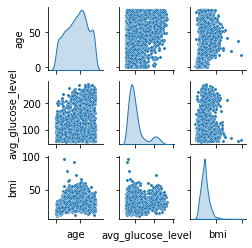

In [156]:
g = sns.pairplot(data=numerical_data,  palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [150]:
X = data[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi']]
y = data['stroke']

Podzielimy dane na testowe i treningowe.

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Implementujemy teraz imputery/ selektory/ pipline preprocesowy

In [157]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# numerical_data = data[['age','avg_glucose_level','bmi']]
# X = data[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi']]
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['gender','hypertension','heart_disease','ever_married','work_type','Residence_type'])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['age','avg_glucose_level','bmi'])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

cat_pipeline.fit_transform(X_train)

array([[0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])